<a href="https://colab.research.google.com/github/danielBrand12/space-objects-classification/blob/main/SpaceObjectsClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls "/content/drive/MyDrive/Modelos 2"

star_classification.csv


# Importamos las librerías necesarias

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KernelDensity
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.decomposition import PCA

# Análisis inicial del dataset

In [5]:
data = pd.read_csv("/content/drive/MyDrive/Modelos 2/star_classification.csv")
data.rename(columns={'class': 'target'}, inplace=True)
data["target"].value_counts()

GALAXY    59445
STAR      21594
QSO       18961
Name: target, dtype: int64

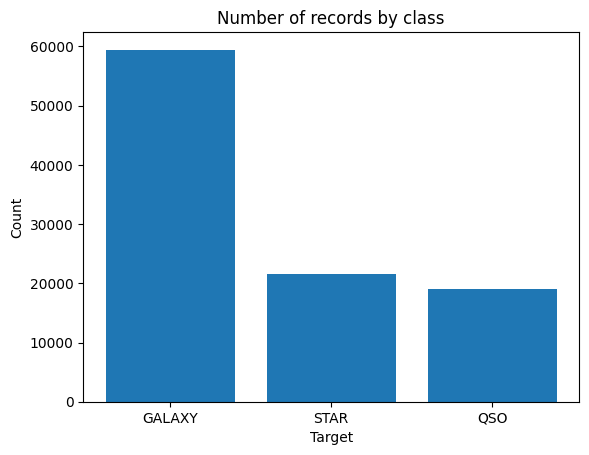

In [36]:
counts = data['target'].value_counts()

plt.bar(counts.index, counts.values, )
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Number of records by class')
plt.show()

In [6]:
data["target"]=[0 if i == "GALAXY" else 1 if i == "STAR" else 2 for i in data["target"]]

# Selección de catacterísticas

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  target       100000 non-null  int64  
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(8)


In [8]:
data = data.drop(["obj_ID", "run_ID", "rerun_ID", "cam_col", "field_ID", "spec_obj_ID", "plate", "MJD", "fiber_ID"], axis=1)

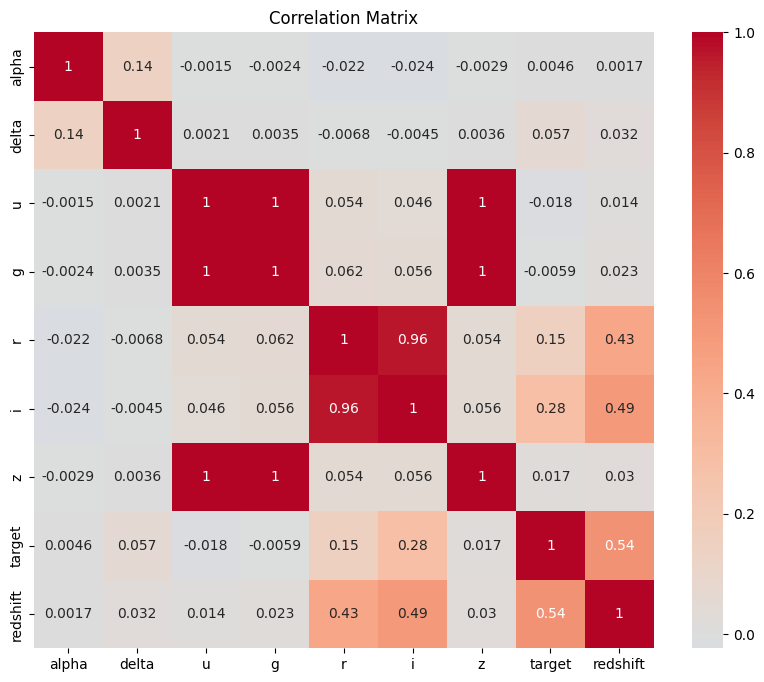

In [9]:
# Compute the correlation matrix
corr_matrix = data.corr()
plt.figure(figsize=(10, 8))
# Plot the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)

plt.title("Correlation Matrix")
plt.show()

In [10]:
corr_matrix["target"].sort_values()

u          -0.017701
g          -0.005915
alpha       0.004552
z           0.017352
delta       0.056643
r           0.150691
i           0.284396
redshift    0.536822
target      1.000000
Name: target, dtype: float64

In [39]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

formula = 'target ~ u + g + r + i + z + redshift + alpha + delta'

model = ols(formula, data=data).fit()

table = sm.stats.anova_lm(model, typ=2)
table

,sum_sq,df,F,PR(>F)
u,391.644980,1.0,1349.813905,1.555206e-293
g,1668.033556,1.0,5748.918031,0.000000e+00
r,40.141624,1.0,138.349078,6.416682e-32
i,85.601839,1.0,295.028810,4.963892e-66
z,4901.048175,1.0,16891.581182,0.000000e+00
redshift,6959.667424,1.0,23986.662256,0.000000e+00
alpha,3.600199,1.0,12.408172,4.276495e-04
delta,90.045714,1.0,310.344732,2.339721e-69
Residual,29012.127570,99991.0,NaN,NaN


# Imbalanced Data
# SMOTE (Synthetic Minority Over-sampling Technique) 
SMOTE es una técnica de sobremuestreo que se utiliza para tratar el desequilibrio de clases en conjuntos de datos. Esta técnica genera muestras sintéticas para la clase minoritaria en función de sus vecinos más cercanos en el espacio de características. Básicamente, SMOTE toma una muestra de la clase minoritaria y genera nuevas muestras sintéticas interpolando entre la muestra original y sus vecinos más cercanos.

La idea detrás de SMOTE es que, en lugar de simplemente duplicar las muestras existentes en la clase minoritaria, es mejor crear nuevas muestras sintéticas que sean lo suficientemente diferentes como para mejorar la generalización del modelo. De esta manera, se puede aumentar la cantidad de datos de la clase minoritaria sin crear redundancias en los datos de entrenamiento.

N. V. Chawla, K. W. Bowyer, L. O. Hall, y W. P. Kegelmeyer, "SMOTE: Synthetic Minority Over-sampling Technique," Journal of Artificial Intelligence Research, vol. 16, pp. 321-357, 2002.

In [40]:
x = data.drop(['target'], axis = 1)
y = data.loc[:,'target'].values
sm = SMOTE(random_state=42)
print('Original dataset shape %s' % Counter(y))
x, y = sm.fit_resample(x, y)
print('Resampled dataset shape %s' % Counter(y))

Original dataset shape Counter({0: 59445, 1: 21594, 2: 18961})
Resampled dataset shape Counter({0: 59445, 2: 59445, 1: 59445})


In [26]:
# class1_data = data[data['target'] == 0]
# class2_data = data[data['target'] == 1]
# class3_data = data[data['target'] == 2]

# class1_sample = class1_data.sample(n=10000, random_state=42)
# class2_sample = class2_data.sample(n=10000, random_state=42)
# class3_sample = class3_data.sample(n=10000, random_state=42)

# reduced_data = pd.concat([class1_sample, class2_sample, class3_sample], axis=0)
# reduced_data = reduced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# x = reduced_data.drop(['target'], axis = 1)
# y = reduced_data.loc[:,'target'].values

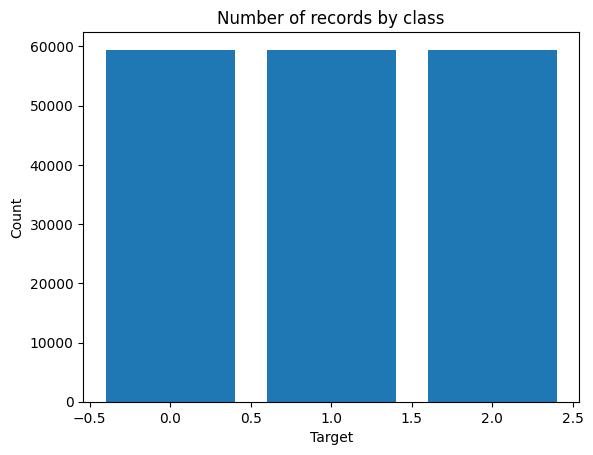

In [41]:
counts = np.unique(y, return_counts=True)
plt.bar(counts[0], counts[1], )
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Number of records by class')
plt.show()

# Scale and Split data


In [28]:
scaler = StandardScaler()
scaler.fit(x)
x = scaler.transform(x)

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 42)

# Train Models


In [31]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(x_train, y_train)

predicted = qda.predict(x_test)
accuracy = accuracy_score(y_test, predicted)
precision, recall, f1score, _ = precision_recall_fscore_support(y_test, predicted, average='weighted')
conf_matrix = confusion_matrix(y_test, predicted)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1score)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.9491919191919191
Precision: 0.9492137692017599
Recall: 0.9491919191919191
F1 Score: 0.9491793863497239
Confusion Matrix:
[[3046   27  234]
 [   3 3288   22]
 [ 216    1 3063]]


In [19]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.2) 
kde.fit(x_train)

predicted = kde.score_samples(x_test)
predicted = (predicted > 0.5).astype(int) # Convertimos las probabilidades en etiquetas binarias
accuracy = accuracy_score(y_test, predicted)
precision, recall, f1score, _ = precision_recall_fscore_support(y_test, predicted, average='weighted')
conf_matrix = confusion_matrix(y_test, predicted)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1score)
print("Confusion Matrix:")
print(conf_matrix)

KDE Accuracy : 0.266


In [32]:
gbt = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3) 

#------------------------------------
#Forward Selection
sfs = SequentialFeatureSelector(gbt, scoring='accuracy', cv=5)

sfs.fit(x_train, y_train)

print("Características seleccionadas:", sfs.get_support())

x_train_forward = sfs.transform(x_train)
x_test_forward = sfs.transform(x_test)

gbt.fit(x_train_forward, y_train)

predicted_fwd = gbt.predict(x_test_forward)
accuracy_fwd = accuracy_score(y_test, predicted_fwd)
precision_fwd, recall_fwd, f1score_fwd, _ = precision_recall_fscore_support(y_test, predicted_fwd, average='weighted')
conf_matrix_fwd = confusion_matrix(y_test, predicted_fwd)
# print("Accuracy_fwd:", accuracy_fwd)
# print("Precision_fwd:", precision_fwd)
# print("Recall_fwd:", recall_fwd)
# print("F1 Score_fwd:", f1score_fwd)
print("Confusion Matrix FWD:")
print(conf_matrix_fwd)

#------------------------------------
#PCA
pca = PCA(n_components=6)
pca.fit(x)
x_train_PCA = pca.transform(x_train)
x_test_PCA = pca.transform(x_test)
gbt.fit(x_train_PCA, y_train)

predicted_PCA = gbt.predict(x_test_PCA)
accuracy_PCA = accuracy_score(y_test, predicted_PCA)
precision_PCA, recall_PCA, f1score_PCA, _ = precision_recall_fscore_support(y_test, predicted_PCA, average='weighted')
conf_matrix_PCA = confusion_matrix(y_test, predicted_PCA)
# print("Accuracy_pca:", accuracy_PCA)
# print("Precision_pca:", precision_PCA)
# print("Recall_pca:", recall_PCA)
# print("F1 Score_pca:", f1score_PCA)
print("Confusion Matrix PCA:")
print(conf_matrix_PCA)

#------------------------------------
#Custom
print("")
print("Custom")
print("")
gbt.fit(x_train, y_train)
predicted = gbt.predict(x_test)
accuracy = accuracy_score(y_test, predicted)
precision, recall, f1score, _ = precision_recall_fscore_support(y_test, predicted, average='weighted')
conf_matrix = confusion_matrix(y_test, predicted)
# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1 Score:", f1score)
print("Confusion Matrix:")
print(conf_matrix)

# -----------------------------------

metrics = {
    'ModeloGBT': [1, 2, 3],
    'Selección de características': ['Forward selection', 'PCA', 'Custom'],
    'Accuracy': [accuracy_fwd, accuracy_PCA, accuracy],
    'Precision': [precision_fwd, precision_PCA, precision],
    'Recall': [recall_fwd, recall_PCA, recall],
    'F1-score': [f1score_fwd, f1score_PCA, f1score]
}

df = pd.DataFrame(metrics, columns=['ModeloGBT', 'Selección de características', 'Accuracy', 'Precision', 'Recall', 'F1-score'])

print(df)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_sequential.py:211: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(


Características seleccionadas: [False False  True  True False  True False  True]
Confusion Matrix FWD:
[[3203   13   91]
 [   3 3310    0]
 [ 200    1 3079]]
Confusion Matrix PCA:
[[2988  234   85]
 [ 131 3180    2]
 [ 229   28 3023]]

Custom

Confusion Matrix:
[[3207   10   90]
 [   2 3311    0]
 [ 202    1 3077]]
   ModeloGBT Selección de características  Accuracy  Precision    Recall  \
0          1            Forward selection  0.968889   0.969171  0.968889   
1          2                          PCA  0.928384   0.929341  0.928384   
2          3                       Custom  0.969192   0.969499  0.969192   

   F1-score  
0  0.968867  
1  0.928514  
2  0.969171  


In [33]:
df

,ModeloGBT,Selección de características,Accuracy,Precision,Recall,F1-score
0,1,Forward selection,0.968889,0.969171,0.968889,0.968867
1,2,PCA,0.928384,0.929341,0.928384,0.928514
2,3,Custom,0.969192,0.969499,0.969192,0.969171


In [34]:
mlp = MLPClassifier(hidden_layer_sizes=(10, 10), activation='relu', solver='adam') 

#------------------------------------
#Forward Selection
sfs = SequentialFeatureSelector(mlp, scoring='accuracy', cv=5)

sfs.fit(x_train, y_train)

print("Características seleccionadas:", sfs.get_support())

x_train_forward = sfs.transform(x_train)
x_test_forward = sfs.transform(x_test)

mlp.fit(x_train_forward, y_train)

predicted_fwd = mlp.predict(x_test_forward)
accuracy_fwd = accuracy_score(y_test, predicted_fwd)
precision_fwd, recall_fwd, f1score_fwd, _ = precision_recall_fscore_support(y_test, predicted_fwd, average='weighted')
conf_matrix_fwd = confusion_matrix(y_test, predicted_fwd)
# print("Accuracy_fwd:", accuracy_fwd)
# print("Precision_fwd:", precision_fwd)
# print("Recall_fwd:", recall_fwd)
# print("F1 Score_fwd:", f1score_fwd)
print("Confusion Matrix FWD:")
print(conf_matrix_fwd)

#------------------------------------
#PCA
pca = PCA(n_components=6)
pca.fit(x)
x_train_PCA = pca.transform(x_train)
x_test_PCA = pca.transform(x_test)
mlp.fit(x_train_PCA, y_train)

predicted_PCA = mlp.predict(x_test_PCA)
accuracy_PCA = accuracy_score(y_test, predicted_PCA)
precision_PCA, recall_PCA, f1score_PCA, _ = precision_recall_fscore_support(y_test, predicted_PCA, average='weighted')
conf_matrix_PCA = confusion_matrix(y_test, predicted_PCA)
# print("Accuracy_pca:", accuracy_PCA)
# print("Precision_pca:", precision_PCA)
# print("Recall_pca:", recall_PCA)
# print("F1 Score_pca:", f1score_PCA)
print("Confusion Matrix PCA:")
print(conf_matrix_PCA)

#------------------------------------
# Custom
print("")
print("Custom")
print("")

mlp.fit(x_train, y_train)

predicted = mlp.predict(x_test)
accuracy = accuracy_score(y_test, predicted)
precision, recall, f1score, _ = precision_recall_fscore_support(y_test, predicted, average='weighted')
conf_matrix = confusion_matrix(y_test, predicted)
# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1 Score:", f1score)
print("Confusion Matrix:")
print(conf_matrix)

# -----------------------------------

metrics = {
    'ModeloMLP': [1, 2, 3],
    'Selección de características': ['Forward selection', 'PCA', 'Custom'],
    'Accuracy': [accuracy_fwd, accuracy_PCA, accuracy],
    'Precision': [precision_fwd, precision_PCA, precision],
    'Recall': [recall_fwd, recall_PCA, recall],
    'F1-score': [f1score_fwd, f1score_PCA, f1score]
}

df = pd.DataFrame(metrics, columns=['ModeloMLP', 'Selección de características', 'Accuracy', 'Precision', 'Recall', 'F1-score'])

print(df)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_sequential.py:211: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings

Características seleccionadas: [False False False  True  True False  True  True]


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Confusion Matrix FWD:
[[3147   44  116]
 [   1 3311    1]
 [ 185    2 3093]]


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Confusion Matrix PCA:
[[3161   40  106]
 [   4 3309    0]
 [ 204    3 3073]]

Custom

Confusion Matrix:
[[3158   51   98]
 [   4 3308    1]
 [ 209    2 3069]]
   ModeloMLP Selección de características  Accuracy  Precision    Recall  \
0          1            Forward selection  0.964747   0.964697  0.964747   
1          2                          PCA  0.963939   0.964036  0.963939   
2          3                       Custom  0.963131   0.963263  0.963131   

   F1-score  
0  0.964666  
1  0.963872  
2  0.963056  


In [35]:
df

,ModeloMLP,Selección de características,Accuracy,Precision,Recall,F1-score
0,1,Forward selection,0.964747,0.964697,0.964747,0.964666
1,2,PCA,0.963939,0.964036,0.963939,0.963872
2,3,Custom,0.963131,0.963263,0.963131,0.963056


In [36]:
svm = SVC(kernel='rbf', C=1, random_state=0)

#------------------------------------
#Forward Selection
sfs = SequentialFeatureSelector(svm, scoring='accuracy', cv=5)

sfs.fit(x_train, y_train)

print("Características seleccionadas:", sfs.get_support())

x_train_forward = sfs.transform(x_train)
x_test_forward = sfs.transform(x_test)

svm.fit(x_train_forward, y_train)

predicted_fwd = svm.predict(x_test_forward)
accuracy_fwd = accuracy_score(y_test, predicted_fwd)
precision_fwd, recall_fwd, f1score_fwd, _ = precision_recall_fscore_support(y_test, predicted_fwd, average='weighted')
conf_matrix_fwd = confusion_matrix(y_test, predicted_fwd)
# print("Accuracy_fwd:", accuracy_fwd)
# print("Precision_fwd:", precision_fwd)
# print("Recall_fwd:", recall_fwd)
# print("F1 Score_fwd:", f1score_fwd)
print("Confusion Matrix FWD:")
print(conf_matrix_fwd)

#------------------------------------
#PCA
pca = PCA(n_components=6)
pca.fit(x)
x_train_PCA = pca.transform(x_train)
x_test_PCA = pca.transform(x_test)
svm.fit(x_train_PCA, y_train)

predicted_PCA = svm.predict(x_test_PCA)
accuracy_PCA = accuracy_score(y_test, predicted_PCA)
precision_PCA, recall_PCA, f1score_PCA, _ = precision_recall_fscore_support(y_test, predicted_PCA, average='weighted')
conf_matrix_PCA = confusion_matrix(y_test, predicted_PCA)
# print("Accuracy_pca:", accuracy_PCA)
# print("Precision_pca:", precision_PCA)
# print("Recall_pca:", recall_PCA)
# print("F1 Score_pca:", f1score_PCA)
print("Confusion Matrix PCA:")
print(conf_matrix_PCA)

#------------------------------------
# Custom
print("")
print("Custom:")
print("")
svm.fit(x_train,y_train)
predicted = svm.predict(x_test)
accuracy = accuracy_score(y_test, predicted)
precision, recall, f1score, _ = precision_recall_fscore_support(y_test, predicted, average='weighted')
conf_matrix = confusion_matrix(y_test, predicted)
# print("Accuracy_pca:", accuracy)
# print("Precision_pca:", precision)
# print("Recall_pca:", recall)
# print("F1 Score_pca:", f1score)
print("Confusion Matrix:")
print(conf_matrix)

# -----------------------------------

metrics = {
    'ModeloSVM': [1, 2, 3],
    'Selección de características': ['Forward selection', 'PCA', 'Custom'],
    'Accuracy': [accuracy_fwd, accuracy_PCA, accuracy],
    'Precision': [precision_fwd, precision_PCA, precision],
    'Recall': [recall_fwd, recall_PCA, recall],
    'F1-score': [f1score_fwd, f1score_PCA, f1score]
}

df = pd.DataFrame(metrics, columns=['ModeloSVM', 'Selección de características', 'Accuracy', 'Precision', 'Recall', 'F1-score'])

df

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_sequential.py:211: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(


Características seleccionadas: [False False  True  True False False  True  True]
Confusion Matrix FWD:
[[3123   79  105]
 [   0 3312    1]
 [ 271    3 3006]]
Confusion Matrix PCA:
[[3036  206   65]
 [   0 3313    0]
 [ 254    9 3017]]

Custom:

Confusion Matrix:
[[3036  206   65]
 [   0 3313    0]
 [ 249    9 3022]]


,ModeloSVM,Selección de características,Accuracy,Precision,Recall,F1-score
0,1,Forward selection,0.953636,0.953958,0.953636,0.953481
1,2,PCA,0.946061,0.946830,0.946061,0.945818
2,3,Custom,0.946566,0.947310,0.946566,0.946325


# Best models

In [38]:
#0.969192 	0.969499 	0.969192 	0.969171
metrics = {
    'Modelo': ["Gradient boosting", "MLPClassifier", "SVM"],
    'Selección de características': ['Custom', 'Forward selection', 'Forward selection'],
    'Accuracy': [0.969192, 0.964747, 0.953636],
    'Precision': [0.969499, 0.964697, 0.953958],
    'Recall': [0.969192, 0.964747, 0.953636],
    'F1-score': [0.969171, 0.964666, 0.953481]
}

df = pd.DataFrame(metrics, columns=['Modelo', 'Selección de características', 'Accuracy', 'Precision', 'Recall', 'F1-score'])
df

,Modelo,Selección de características,Accuracy,Precision,Recall,F1-score
0,Gradient boosting,Custom,0.969192,0.969499,0.969192,0.969171
1,MLPClassifier,Forward selection,0.964747,0.964697,0.964747,0.964666
2,SVM,Forward selection,0.953636,0.953958,0.953636,0.953481
